# EN4353-Radar and Navigation 
# Assignment 2

160450J- Nusri M.N.M

If any Image/Equation is not rendering in Jupyter Notebook, Please use Google Colab

Colab link : https://colab.research.google.com/drive/1xMs3bP9BxVc7IyVQa7TiPaKHZOxWbI-_?usp=sharing

In [20]:
import pandas as pd
import csv
import cmath
import matplotlib.pyplot as plt
import seaborn as sns
import math
from itertools import cycle
import numpy as np

In [21]:
# realData_n=pd.read_csv("imag_component.csv",header=None,squeeze=True)
# ImagData_n=pd.read_csv("real_component.csv",header=None,,squeeze=True)

In [22]:
real_link = 'https://raw.githubusercontent.com/NusriNalir/Radar_Assignment_2/main/real_component.csv'
imag_link = 'https://raw.githubusercontent.com/NusriNalir/Radar_Assignment_2/main/imag_component.csv'
realData_n = pd.read_csv(real_link,sep=';',header=None,squeeze=True)
ImagData_n = pd.read_csv(imag_link,sep=';',header=None,squeeze=True)

# Q1

**Radar Description:** \
Pulse Repetition Frequency = 1800Hz\
Horizontal Beam Width = 2  \
Number of Revs per minute = 12 \
Radar frequency = 720MHz 


---


Sampling Frequency  (Fs(orig))=1080kHz \
Number of range slots= 30 \
Number of samples= 27000 \
Number of pulses transmitted = 27000/30 = 900 \


---


I(t)=A(t)sin(θ(t)) \
Q(t)=A(t)cos(θ(t)) \
θ(t)=2π$f_d$t−π \
Here |A(t)| is assumed to be same for 3 consecutive samples \








Impulse response of MTI canceller  **h[n]=δ[n]−4δ[n−1]+δ[n−2]**

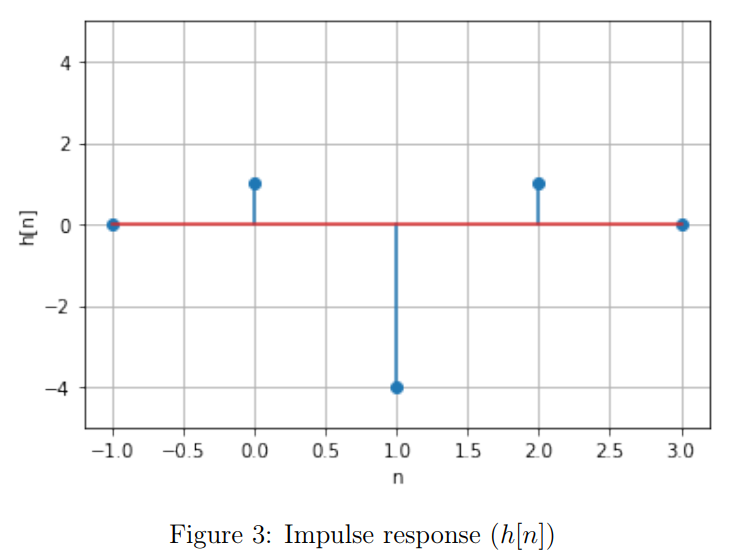

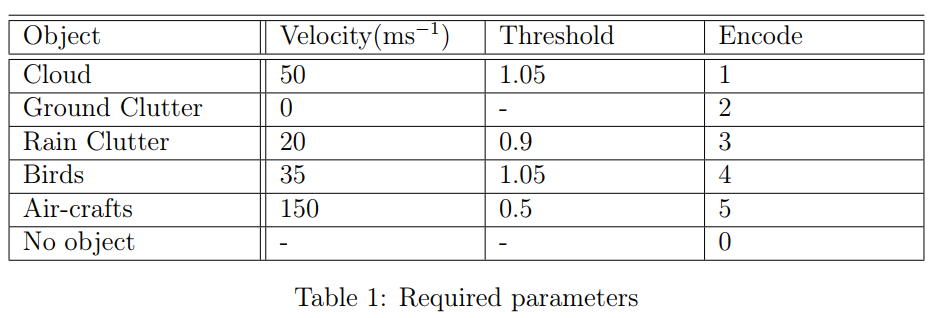

In [23]:
F_s_orig = 1080*1000 #sampling freq
M = 20 # Downsampled by 20
F_s = F_s_orig/M
PRF = 1800 # Pulse repitition freq
Radar_Fr = 720*10e6 # Radar frequency 720MHz
light_speed = 3*10e8 #speed of light
theta_H = 2 # in degrees
RPM = 12 # RPM


In [24]:
df_W = realData_n+1j*ImagData_n
W_n = df_W.to_numpy()
C = 30

L = len(W_n)
N = int(len(W_n)/C)

param_dict = {'Cloud_Clutter':[50,1.05,1],'Ground_Clutter':[0,None,2],'Rain_Clutter':[20,0.9,3],'Birds':[35,1.05,4],'Air-Crafts':[150,0.5,5],'No_object':[None,None,0]}


# Q1

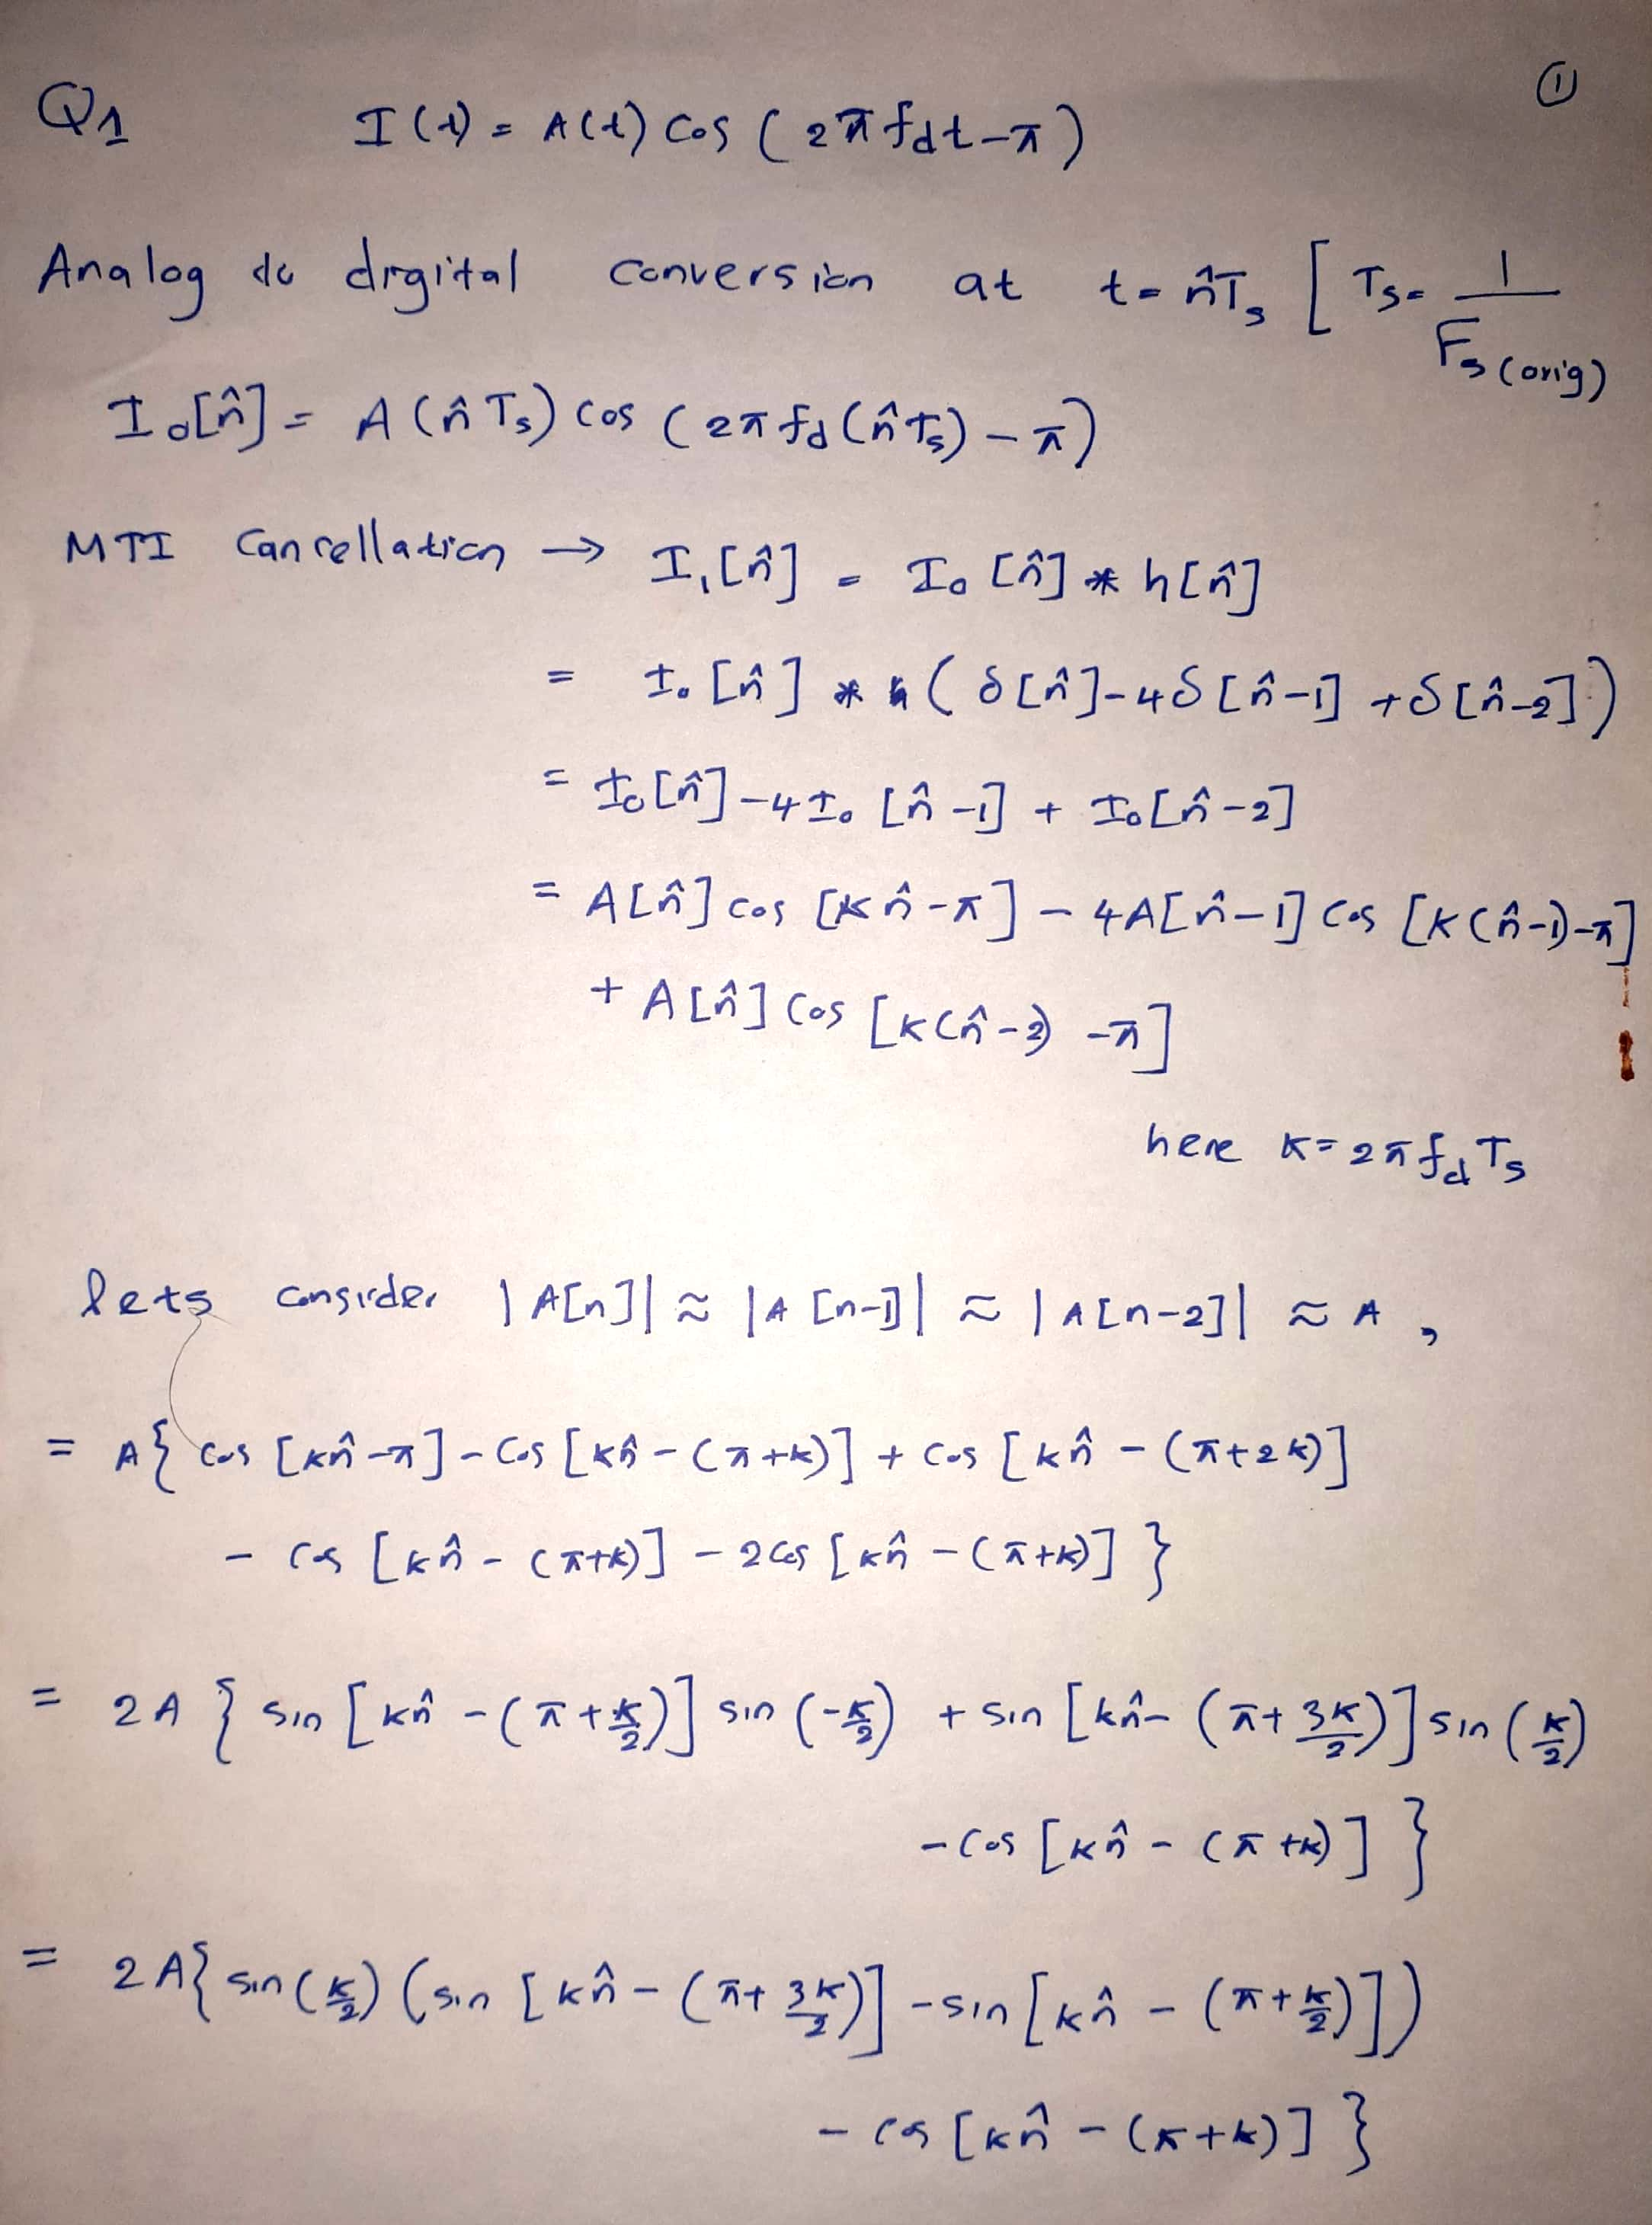

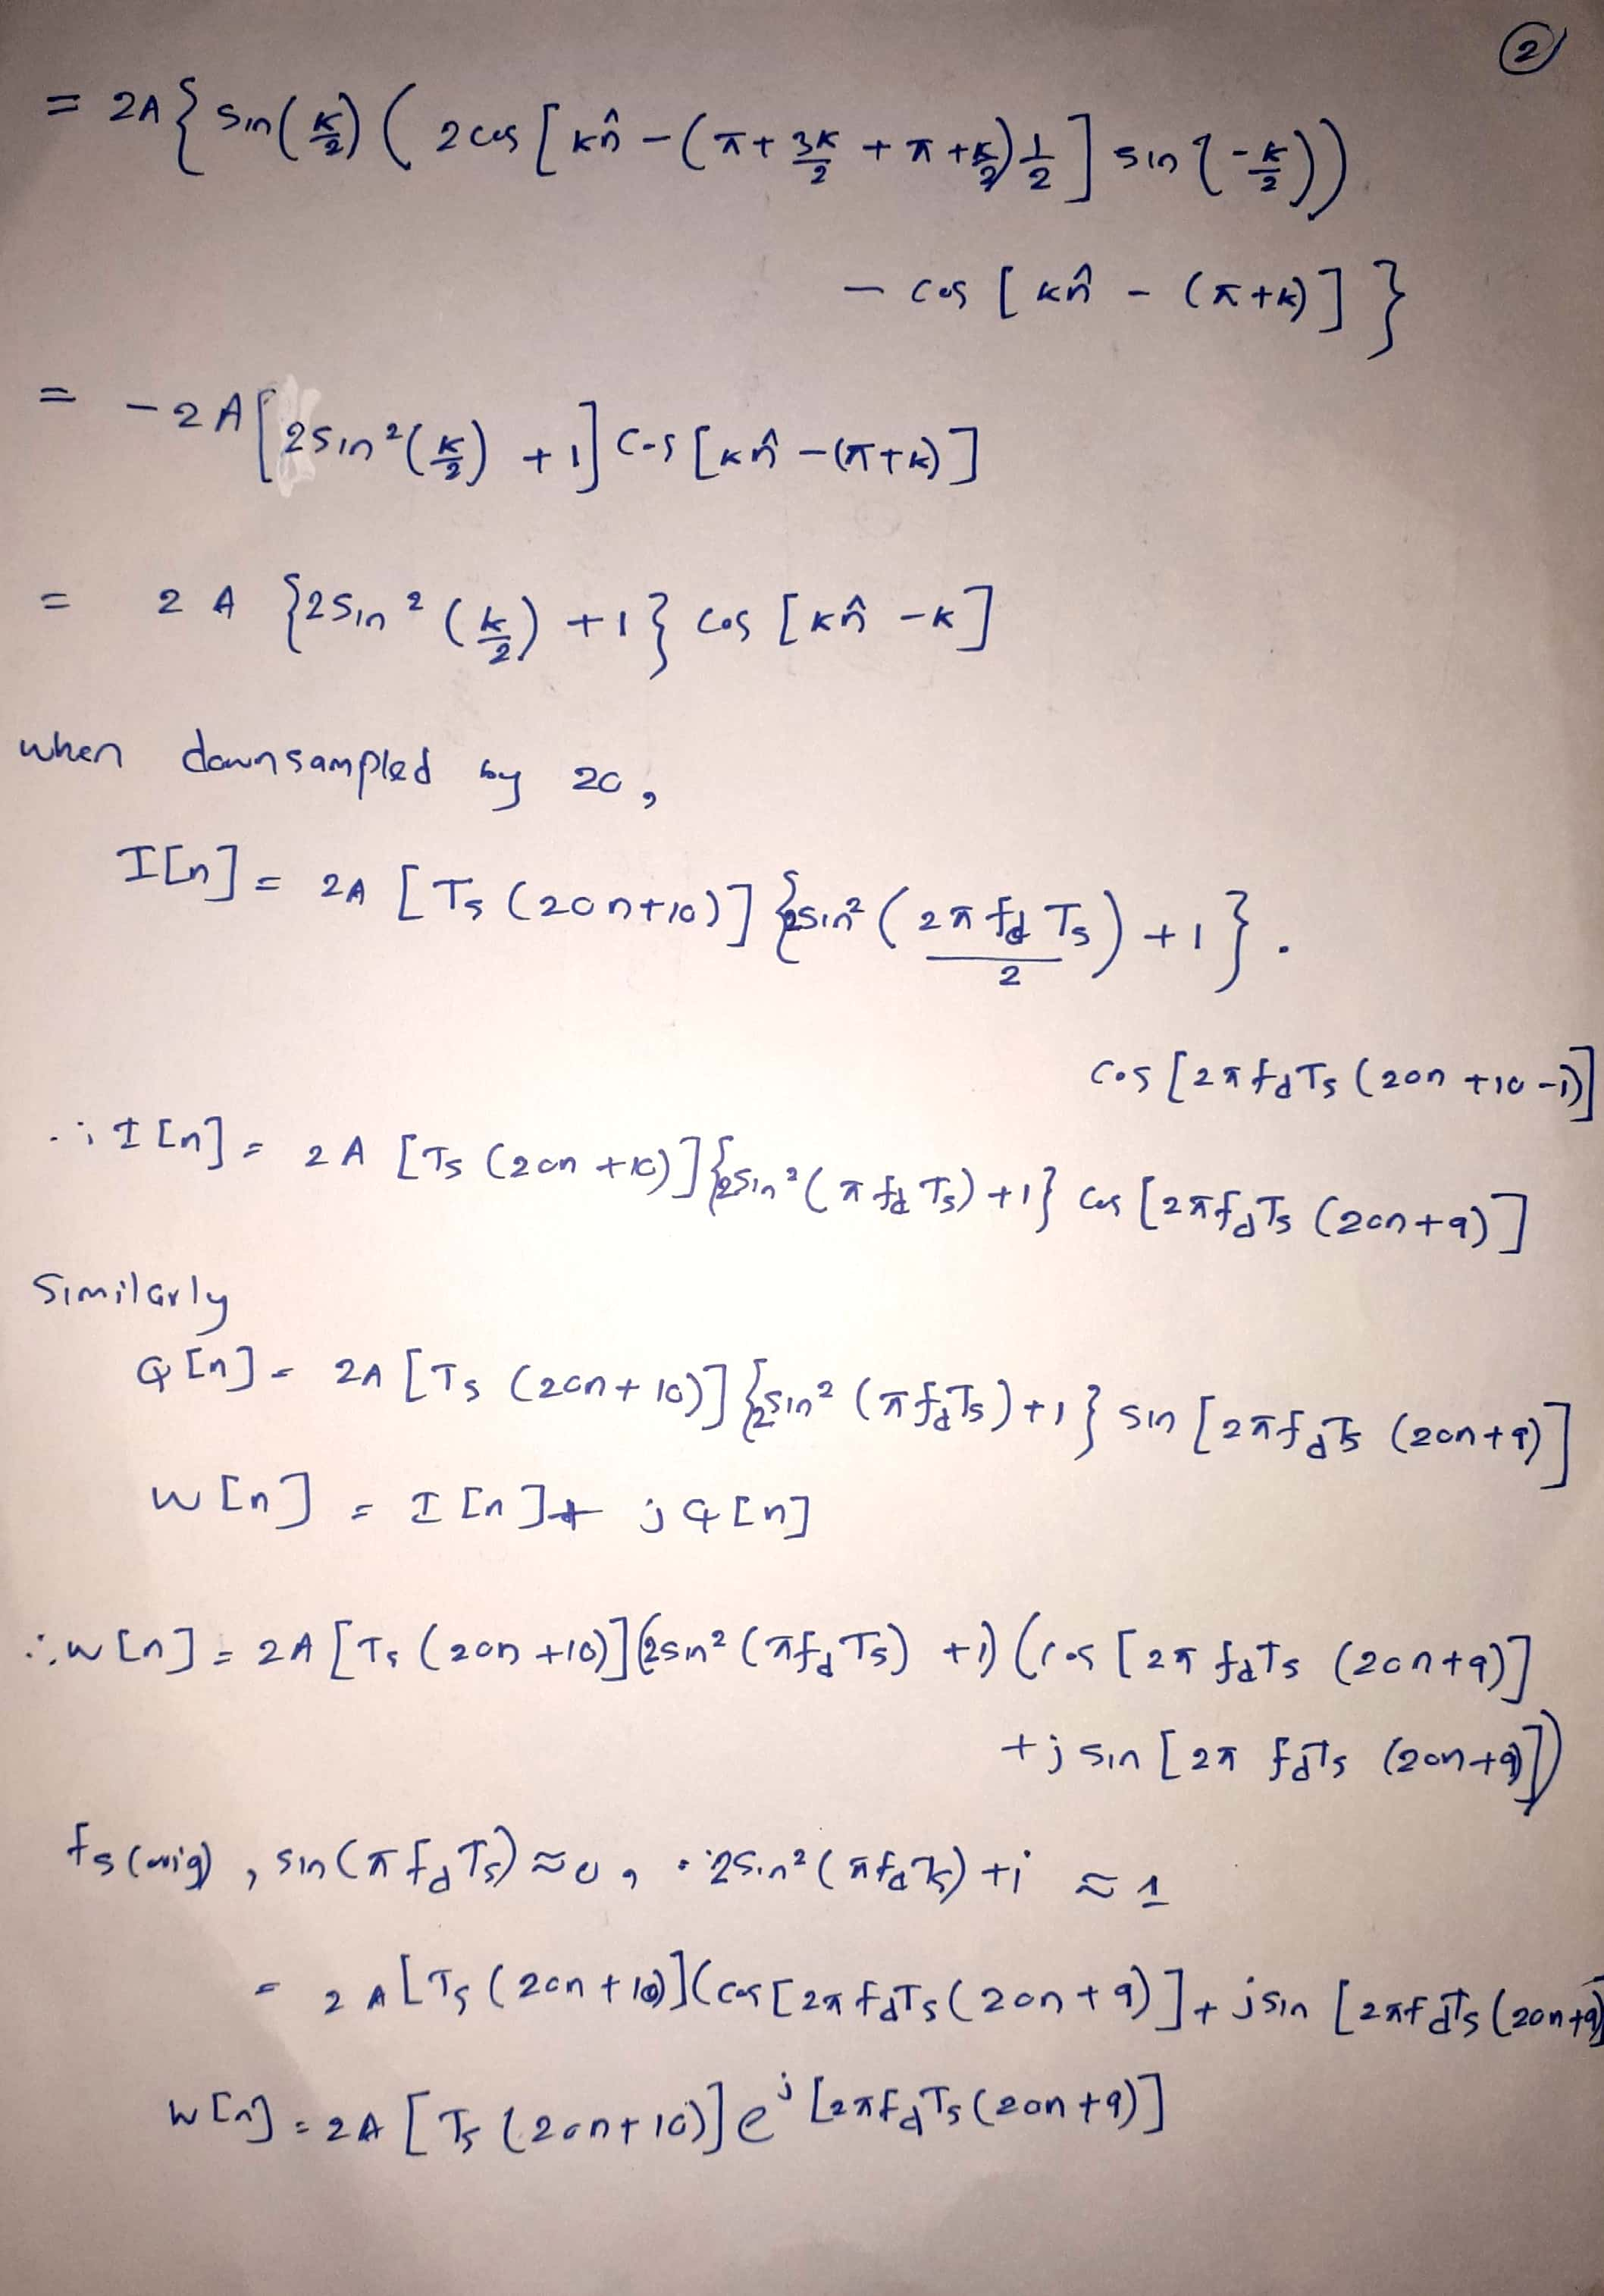

If above images are not visible in jupyter notebook, please use Google colab

# Q2
we can represent data matrix range bins as \
W[n]=I[n]+jQ[n]

in the below segment we have plot the \


1.   Magnitude of W[n]
2.   phase of w[n]







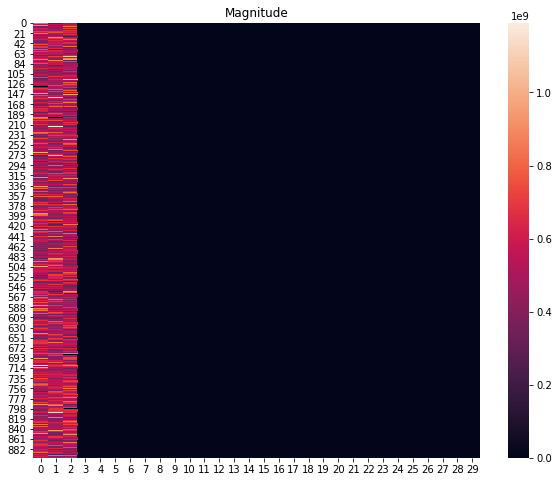

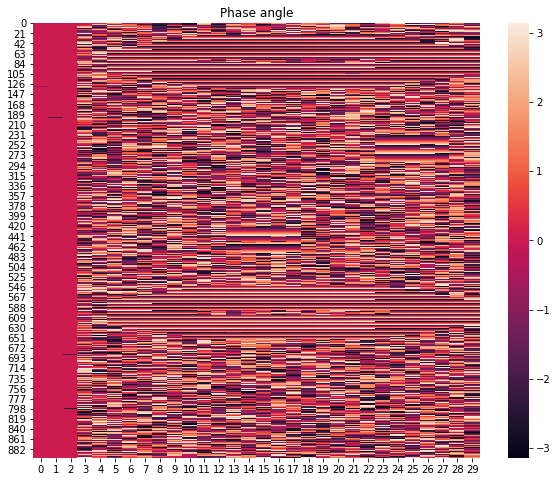

In [40]:
# reshape the data s.t. we have 30 range bins
RadarMatrix = W_n.reshape(N,C)

# calculate the magnitude and plot
magn_D = abs(RadarMatrix)
plt.figure(figsize = (10,8))
magn_graph = sns.heatmap(magn_D, square=False,annot=False,cbar=True)
plt.title('Magnitude')
plt.show()

# calculate the phase values and plot
phase = np.vectorize(lambda x: cmath.phase(x))
phase_D = phase(RadarMatrix)
plt.figure(figsize = (10,8))
phase_graph= sns.heatmap(phase_D, square=False,annot=False,cbar=True)
plt.title('Phase angle')
plt.show()


If we consider Ground clutter, its velocity is 0.\
when $f_d$→0,\
2π$f_d$Ts (20n+9) →0

Therefore the phase angle $\theta(t)$ approaches 0, for Ground clutter. This relationship can be used to implement the zero velocity filter, which will filter the ground clutter.

we can implement the zero velocity filter by using a threshold such that, \
if the phase anglr is less than the threshold we can zero out them, and keep the value as it is otherwise.

# Q3

In the following we have assumed that first 3 range bins are the bins that contain ground clutter.

lets visualize the phase values of Bins with ground clutter and bins without ground clutter.

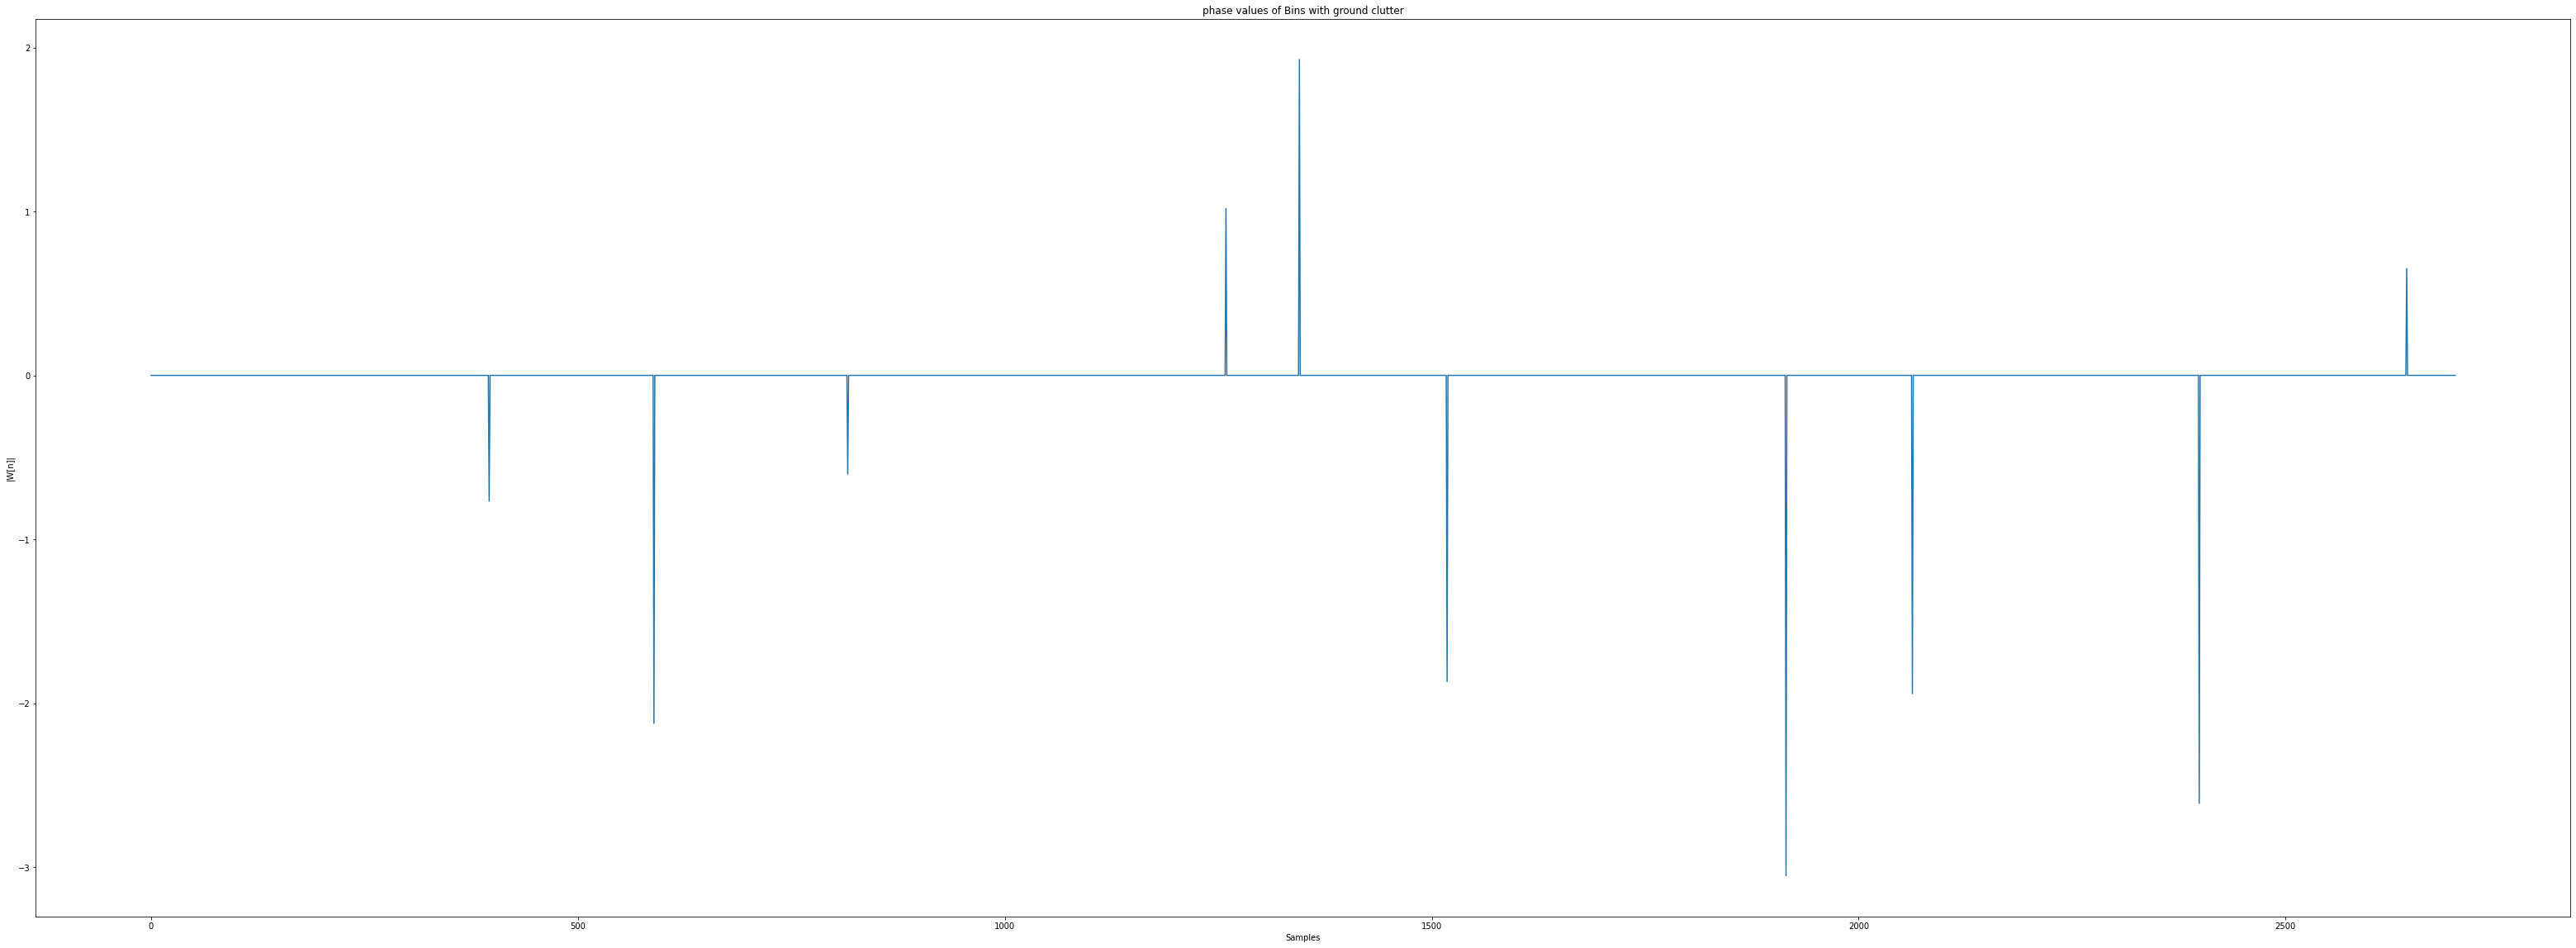

In [26]:
Ground_cl = phase_D[:,0:3].flatten()  # seperate out first 3 coloumns from the Radar matrix
plt.figure(figsize=(55, 20))
ax1=plt.plot(Ground_cl)
ax1=plt.ylabel('|W[n]|')
ax1=plt.xlabel('Samples')
ax1=plt.title('phase values of Bins with ground clutter')
plt.show()

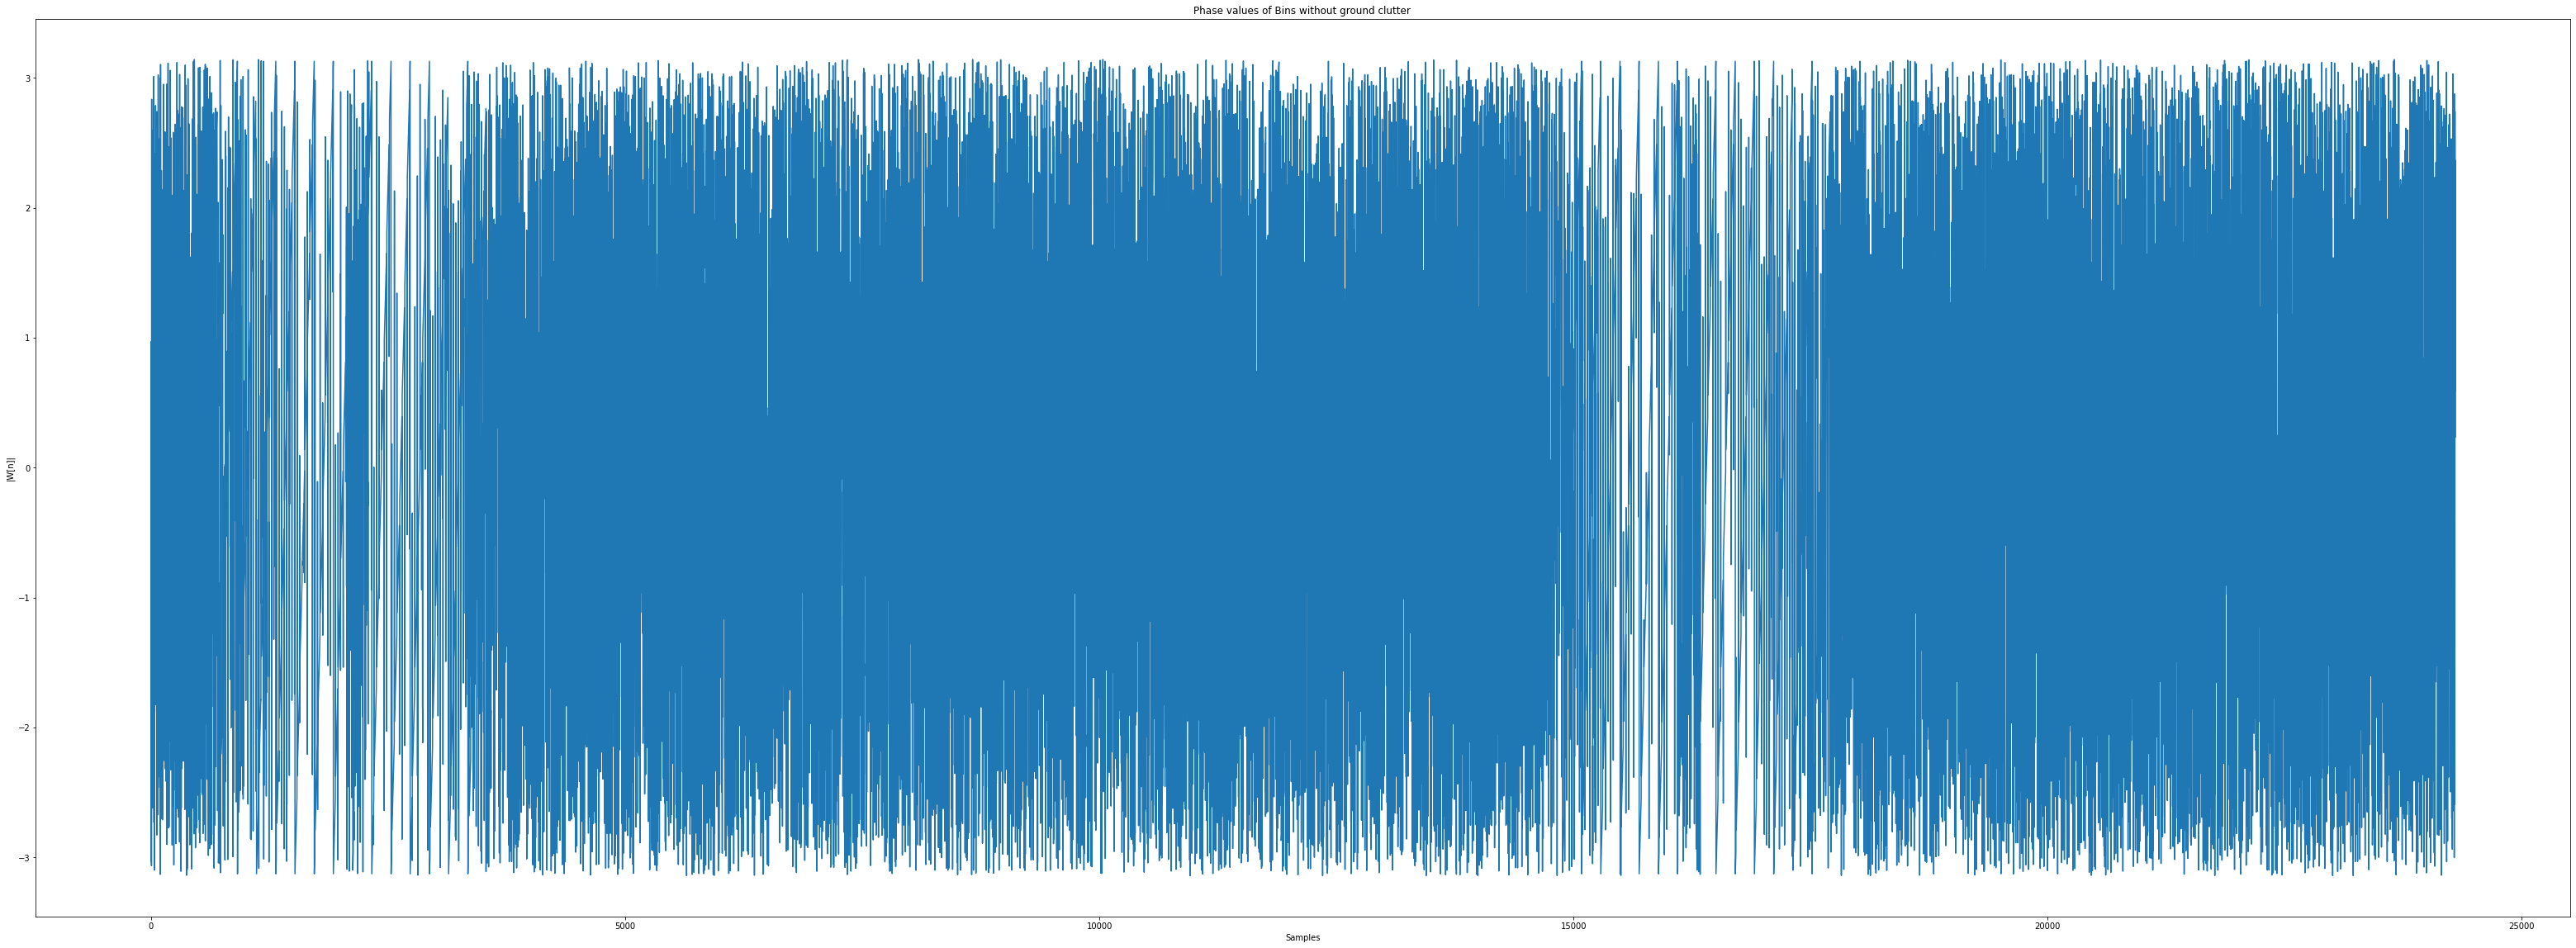

In [27]:
Other_bins = phase_D[:,3:].flatten()  # rest of the 27 coloumns of the Radar Matrix
plt.figure(figsize=(55, 20))
ax2=plt.plot(Other_bins)
ax2=plt.ylabel('|W[n]|')
ax2=plt.xlabel('Samples')
ax2=plt.title('Phase values of Bins without ground clutter ')
plt.show()

## Zero Velocity Filter
in the above graph we can see that phase of the bins without ground clutter are close to zero. \
Therefore threshold value to remove ground clutter in the zero velocity filter is selected as $10^{-3}$.

Text(0.5, 1.0, 'After filtering ground clutter by the Zero Velocity Filter')

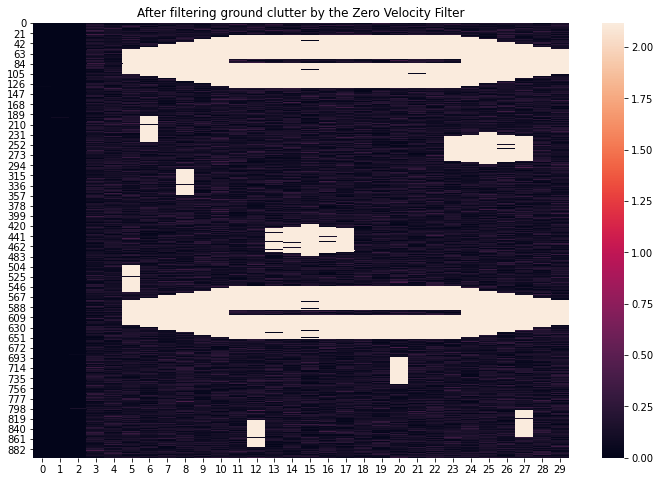

In [42]:

threshold0 = 2e-3
def ZeroVelocityFilter(RadarMatrix,threshold):
  phase_DM = phase(RadarMatrix)
  filt_DM = np.where(threshold<abs(phase_DM),RadarMatrix,0)
  GC_DM0 = np.where(threshold<abs(phase_DM),0,2) #encode GC
  return filt_DM,GC_DM0

Clutter_filterd,GroundC_DM = ZeroVelocityFilter(RadarMatrix, threshold0) #Encoding clutter to 2
Clutter_filterd_mag = abs(Clutter_filterd)
# plot
plt.figure(figsize = (12,8))
ax = sns.heatmap(Clutter_filterd_mag, square=False,annot=False,cbar=True)
ax.set_title('After filtering ground clutter by the Zero Velocity Filter')

# Q4

In [29]:
color_cycle = cycle('bgrcmyk')
def plot_fft(fft_matrix,dopl_frq,F_s,single_bin = 0):
  fft_abs = np.abs(fft_matrix)
  N = len(fft_matrix)
  # Plot the positive and Negative frequencies.
  f_pos = np.arange(0, F_s/2, step=F_s/N)
  f_neg = np.arange(-F_s/2, 0, step=F_s/N)

  plt.figure(figsize=(25, 10))
  ax=plt.ylabel('$|W(f)|^2$')
  ax=plt.xlabel('Frequency(Hz)')
  ax=plt.title('FFT of W[n]')
  ax = plt.xticks(np.arange(-F_s/2,F_s/2,(F_s*30)/N))
  if single_bin:
    col0 = next(color_cycle)
  else:
    col0=None
  plt.plot(f_pos, fft_abs[:(N//2)],color=col0)
  plt.plot(f_neg, fft_abs[(N//2):],color=col0)

# plot the legend
  for keys,frq in dopl_frq.items():
      col = next(color_cycle)
      if frq!=None:
        plt.vlines(x=frq,ymin=0,ymax=max(fft_abs.flatten())+50,linestyles=':',colors=col,label=keys)
        plt.vlines(x=-frq,ymin=0,ymax=max(fft_abs.flatten())+50,linestyles=':',colors=col,label=keys)
  
  handles, labels = plt.gca().get_legend_handles_labels() 
  labels, ids = np.unique(labels, return_index=True)
  handles = [handles[i] for i in ids]
  plt.legend(handles, labels, loc='best')
  plt.show()
  return None

{'Cloud_Clutter': 240.0, 'Ground_Clutter': 0.0, 'Rain_Clutter': 96.0, 'Birds': 168.0, 'Air-Crafts': 720.0, 'No_object': None}


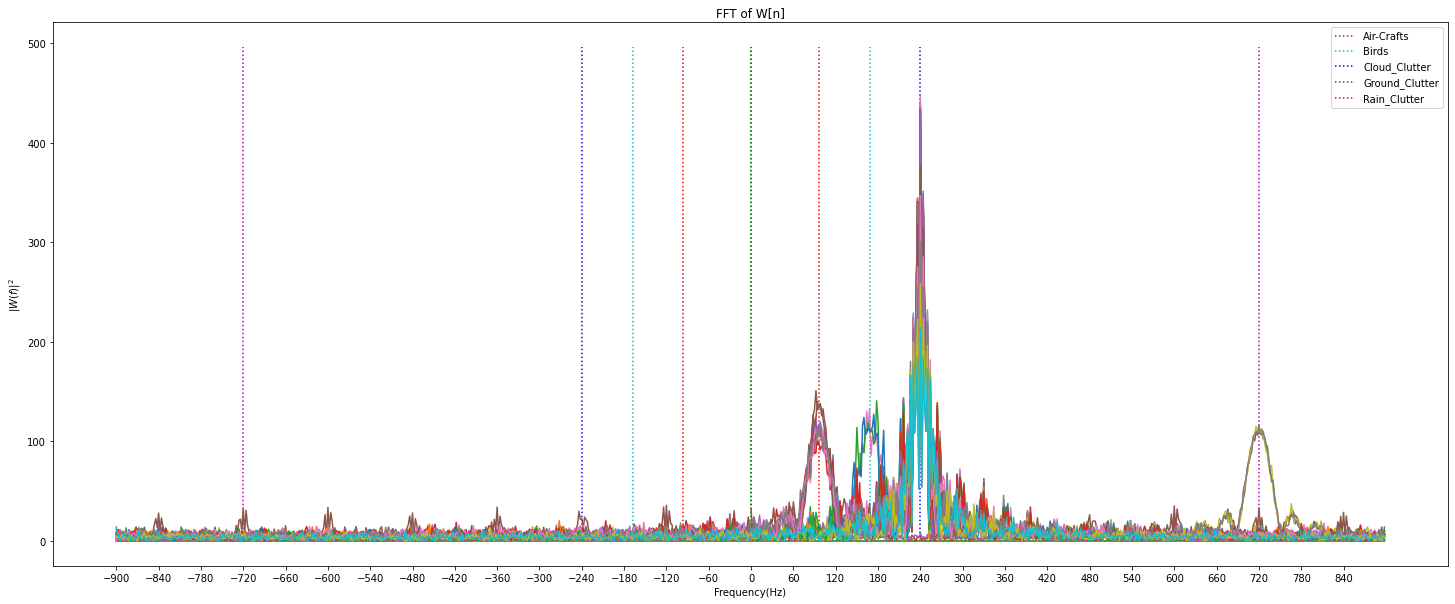

In [30]:
# Get DFT of the ground clutter filtered RadarMatrix
fft_matrix = np.fft.fft(Clutter_filterd[:,:],axis=0)  # Compute the one-dimensional discrete Fourier Transform
#calculate doppler frequencies
dopler_dict = {}
for keys,vals in param_dict.items():
  Velocity_val = vals[0]
  if Velocity_val!=None:
    dopl_freq = 2*Velocity_val/(light_speed/Radar_Fr)  # fd= 2v/lambda
    dopler_dict[keys] = dopl_freq  
  else:
    dopler_dict[keys] = None

print(dopler_dict)

plot_fft(fft_matrix,dopler_dict,PRF,0)

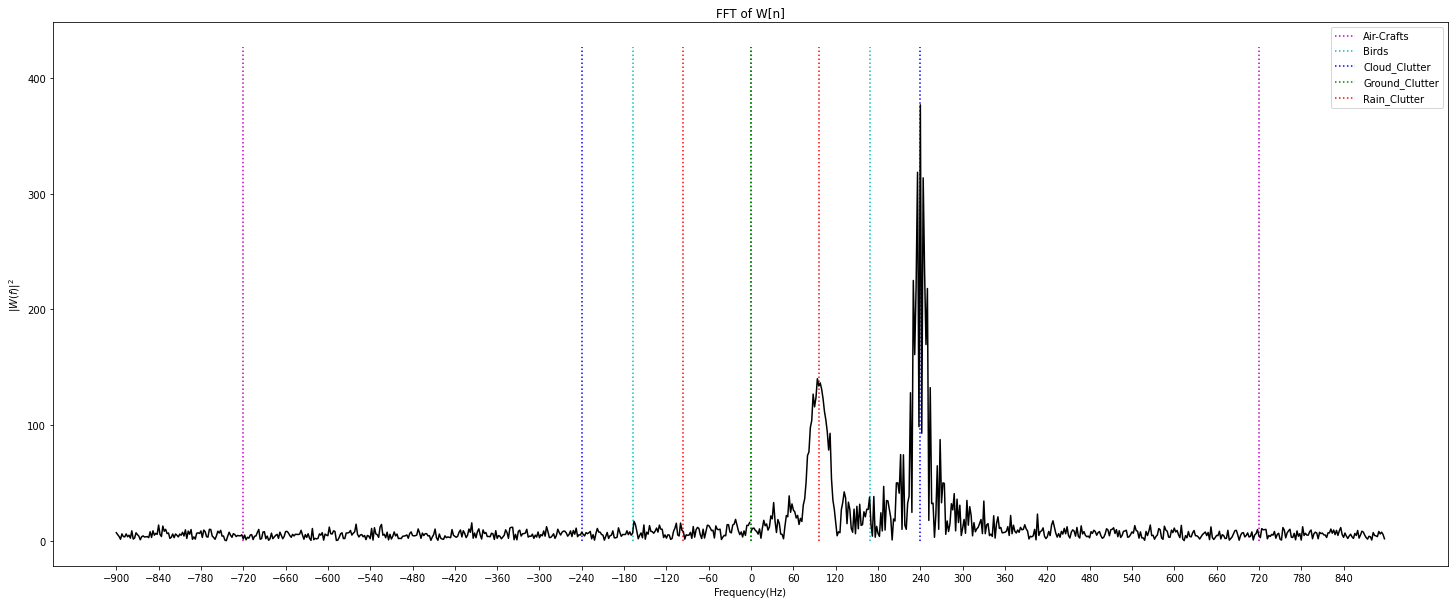

In [31]:
#get FFt for single range bin 
plot_fft(fft_matrix[:,25],dopler_dict,PRF,1)

**Determine a suitable bandwidth for the velocity filters**

we select the Bandwith of the filter as **72Hz**, by observation.

In [32]:
BW= 36 #Hz

# Q5

**Filter bank implementation**

Ideal rectangular filters was chosen as the bandpass filter for simplicity.

In [33]:
# Band pass filter implementation
def BandPass(cutoff_L,cutoff_R,fs,N,plot):
  L_idx = cutoff_L
  R_idx = cutoff_R
  positive_f = np.arange(0, fs / 2, step=fs / N)
  H_pos = 1. * ((positive_f >= L_idx) & (positive_f <= R_idx))
  negative_f = np.arange(-fs / 2, 0, step=fs / N)
  H_neg = 0. * ((positive_f >= L_idx) & (positive_f <= R_idx)) 
  H = np.concatenate([H_pos, np.flip(H_neg)])
  H = H.reshape(H.shape[0], 1) 
  if plot:
    plt.plot(H)
  return H   


we pass W[f] through the doppler filter bank with different cut off frequencies.\
if the output of the doppler filter is 

[i]=$W_i$[f] \
$W_i$[f]= W[f] ∗ BandPassFilter[fc−BW,fc+BW] \
$W_i$[n]= ifft($W_i$[f])

after the inverse DFT operation, we perform the thresholding. \

we get the final output matrix such that, \
if the W_final[n] is greater than the threshold[i], we encode it accordingly and otherwise we make it zero.

In [34]:
#Doppler Filter Bank
dict_final = {}
for keys,values in dopler_dict.items():
  if (values !=None and values!=0):
    #  filter in freq domain
    filt = BandPass(values-BW,values+BW,PRF,N,0)
    # applying the filter 
    FFT_filt = np.multiply(fft_matrix[:,:],filt)  
    # inverse FFT  
    DM_dopl_filt = np.fft.ifft(FFT_filt[:,:],axis=0) 
    threshold = param_dict[keys][1]
    encode = param_dict[keys][2]
    #Perform Thresholding and then encoding
    DM_final = (abs(DM_dopl_filt)>=threshold)*encode     
    #write final matrix to dict
    dict_final[keys] = [DM_final,filt,abs(DM_dopl_filt)] 
    #saving the final matrix to in to .csv files
    np.savetxt(keys+".csv", DM_final, delimiter=",")
    print(keys,' ==> ',values-BW," - ",values+BW,'Hz')

Cloud_Clutter  ==>  204.0  -  276.0 Hz
Rain_Clutter  ==>  60.0  -  132.0 Hz
Birds  ==>  132.0  -  204.0 Hz
Air-Crafts  ==>  684.0  -  756.0 Hz


In [35]:
def generate_heatmap(DataMatrix,dict_label,title):
  f,ax = plt.subplots(figsize=(10,8))
  ax.set_title(title)

  n=len(dict_label)
  cmap = sns.color_palette('tab20', n)
  ax = sns.heatmap(DataMatrix, cmap=cmap)
  colorbar = ax.collections[0].colorbar
  
  r = colorbar.vmax - colorbar.vmin
  colorbar.set_ticks([colorbar.vmin + 0.5 * r / (n) + r * i / (n) for i in range(n)])
  lbl= list(dict_label.keys())

  lbl[0],lbl[1]=lbl[1],lbl[0]
  colorbar.set_ticklabels(lbl)
  

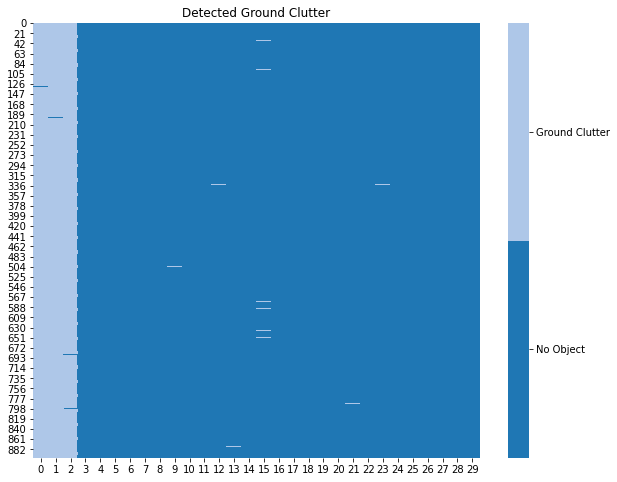

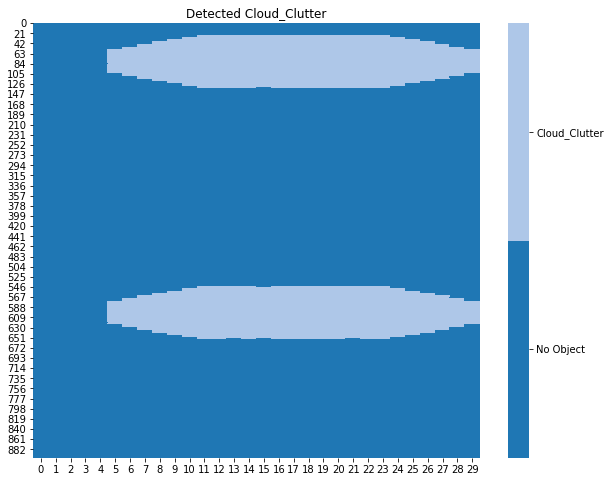

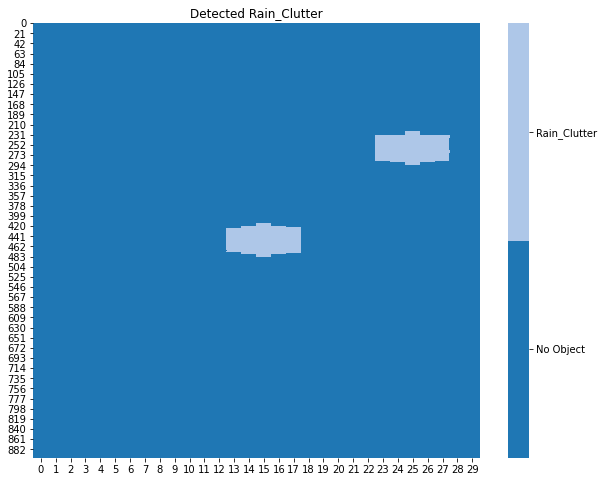

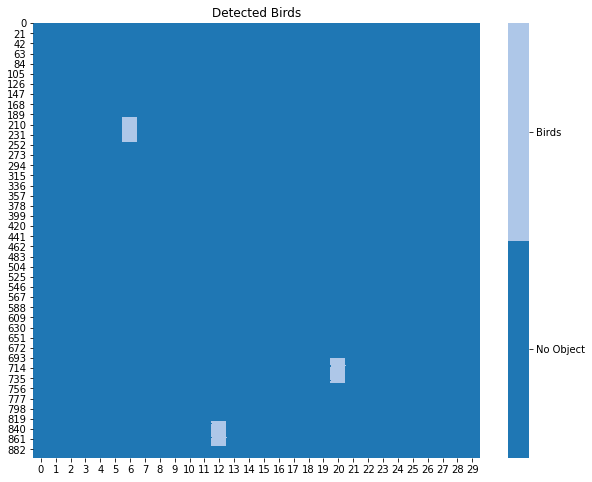

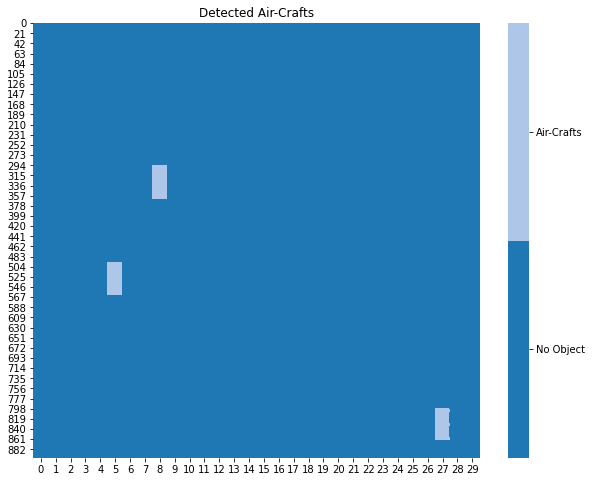

In [36]:
all_DM = GroundC_DM.copy()

title = 'Detected Ground Clutter'
px= generate_heatmap(GroundC_DM,{'Ground Clutter':1,'No Object':0},title,)
#saving Ground clutter 1st
np.savetxt("Ground_Clutter.csv", GroundC_DM, delimiter=",") 
for keys,vals in dict_final.items():
  DM_plot = vals[0]
  all_DM +=DM_plot
  title = 'Detected '+keys
  px = generate_heatmap(DM_plot,{keys:np.max(DM_plot),'No Object':0},title,)



# Final Result: 
**Encoded Radar Matrix**

['No_object', 'Cloud_Clutter', 'Ground_Clutter', 'Rain_Clutter', 'Birds', 'Air-Crafts']


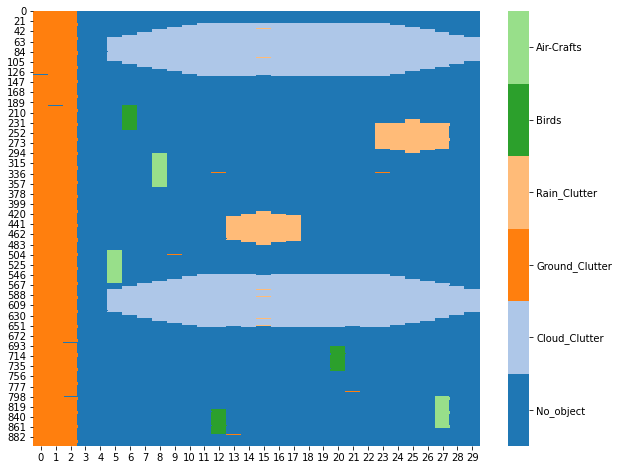

In [37]:
f,ax = plt.subplots(figsize=(10,8))
vmap = param_dict
n=len(vmap)
cmap = sns.color_palette('tab20', n)  # defining the colour map
ax = sns.heatmap(all_DM, cmap=cmap)  # ploting the data matrix with all encoded data
colorbar = ax.collections[0].colorbar
r = colorbar.vmax - colorbar.vmin
colorbar.set_ticks([colorbar.vmin + 0.5 * r / (n) + r * i / (n) for i in range(n)])
lbl1=list(vmap.keys())
lbl1.insert(0, lbl1.pop())
print(lbl1)
colorbar.set_ticklabels(lbl1)